<a href="https://colab.research.google.com/github/osmarbraz/sri/blob/main/5_2_Embeddings_BERT_Huggingface_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#BERT Embeddings pt-br usando Transformers by HuggingFace


Exemplo de embeddings de embeddings de palavras e sentenças utilizando o BERT com a biblioteca HuggingFace.

**Artigo Original:**

http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

**Notebook Original:**
https://colab.research.google.com/drive/1ZQvuAVwA3IjybezQOXnrXMGAnMyZRuPU




# Introdução



### História

2018 foi um ano inovador na PNL. A transferência de aprendizado, particularmente modelos como o ELMO de Allen AI, o Open-GPT da OpenAI e o BERT do Google, permitiu que os pesquisadores quebrassem vários benchmarks com o mínimo de ajuste fino específico da tarefa e forneceu ao restante da comunidade da PNL modelos pré-treinados que poderiam facilmente (com menos dados) e menos tempo de computação) sejam ajustados e implementados para produzir resultados de última geração. Infelizmente, para muitos iniciantes na PNL e mesmo para alguns praticantes experientes, a teoria e a aplicação prática desses poderosos modelos ainda não são bem conhecidas.



### O que é  BERT?

O BERT (Representações de codificadores bidirecionais da Transformers), lançado no final de 2018, é o modelo que usaremos neste tutorial para fornecer aos leitores uma melhor compreensão e orientação prática para o uso de modelos de aprendizado de transferência na PNL. O BERT é um método de pré-treinamento de representações da linguagem que foi usado para criar modelos que os profissionais da PNL podem baixar e usar gratuitamente. Você pode usar esses modelos para extrair recursos de linguagem de alta qualidade dos dados de texto ou ajustá-los em uma tarefa específica (classificação, reconhecimento de entidade, resposta a perguntas etc.) com seus próprios dados para produzir o estado do previsões de arte.

### Porque BERT embeddings?

Neste tutorial, usaremos o BERT para extrair recursos, como vetores de incorporação de palavras e sentenças, a partir de dados de texto. O que podemos fazer com esses vetores de incorporação de palavras e sentenças? Primeiro, essas incorporações são úteis para a expansão de palavras-chave / pesquisa, pesquisa semântica e recuperação de informações. Por exemplo, se você deseja comparar perguntas ou pesquisas do cliente com perguntas já respondidas ou pesquisas bem documentadas, essas representações o ajudarão a recuperar com precisão os resultados correspondentes à intenção e ao significado contextual do cliente, mesmo se não houver sobreposição de palavra-chave ou sentença.

Segundo, e talvez mais importante, esses vetores são usados ​​como entradas de recursos de alta qualidade para modelos posteriores. Modelos de PNL, como LSTMs ou CNNs, exigem entradas na forma de vetores numéricos, e isso normalmente significa traduzir recursos como o vocabulário e partes do discurso em representações numéricas. No passado, as palavras eram representadas como valores indexados exclusivamente (codificação one-hot), ou mais útil como incorporação de palavras neurais em que as palavras do vocabulário são comparadas com as incorporação de recursos de comprimento fixo resultantes de modelos como Word2Vec ou Fasttext. O BERT oferece uma vantagem sobre modelos como o Word2Vec, porque, embora cada palavra tenha uma representação fixa no Word2Vec, independentemente do contexto em que a palavra aparece, o BERT produz representações de palavras que são dinamicamente informadas pelas palavras ao seu redor. Por exemplo, dadas duas sentenças:

* "The man was accused of robbing a bank."
* "The man went fishing by the bank of the river."

traduzido(modificado)

* "O homem foi acusado de assaltar um banco."
* "O homem foi sentar no banco da praça."

O Word2Vec produziria a mesma palavra incorporação para a palavra "banco" em ambas as sentenças, enquanto em BERT a palavra incorporação para "banco" seria diferente para cada sentença. Além de capturar diferenças óbvias como a polissemia, as inserções de palavras informadas pelo contexto capturam outras formas de informação que resultam em representações de recursos mais precisas, o que, por sua vez, resulta em melhor desempenho do modelo.

Do ponto de vista educacional, um exame atento das combinações de palavras do BERT é uma boa maneira de se molhar com o BERT e sua família de modelos de aprendizado de transferência, além de estabelecer alguns conhecimentos e contextos práticos para entender melhor os detalhes internos do modelo em tutoriais posteriores.

Avante!

## Preparação do ambiente
Preparação do ambiente para análise e tratamento de perguntas

###Tratamento de logs

In [ ]:
# Biblioteca de logging
import logging

# Formatando a mensagem de logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### Identificando o ambiente Colab

In [ ]:
# Se estiver executando no Google Colaboratory
import sys
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = 'google.colab' in sys.modules

# 1 Carregando BERT Pré-Treinado 

Instale a interface pytorch para o BERT by Hugging Face. (Esta biblioteca contém interfaces para outros modelos de linguagem pré-treinados, como o GPT e o GPT-2 da OpenAI.)

Selecionamos a interface pytorch porque ela encontra um bom equilíbrio entre as APIs de alto nível (que são fáceis de usar, mas não fornecem informações sobre como as coisas funcionam) e o código do tensorflow (que contém muitos detalhes, mas muitas vezes nos desvia lições sobre o fluxo tensor, quando o objetivo aqui é o BERT!).

Se você estiver executando esse código no Google Colab, precisará instalar esta biblioteca sempre que se reconectar; a célula a seguir cuidará disso para você.

In [ ]:
# Instala a última versão da biblioteca
##!pip install transformers

# Instala uma versão específica da biblioteca
!pip install -U transformers==4.26.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



Agora vamos importar pytorch, o modelo pré-treinado BERT e um tokenizer BERT. Explicaremos o modelo BERT em detalhes em um tutorial posterior, mas este é o modelo pré-treinado lançado pelo Google, que funcionou por muitas e muitas horas na Wikipedia e no [Book Corpus](https://arxiv.org/pdf/1506.06724.pdf), um conjunto de dados contendo 10.000 livros de diferentes gêneros. Esse modelo é responsável (com uma pequena modificação) por superar os benchmarks de PNL em várias tarefas. O Google lançou algumas variações dos modelos BERT, mas o que usaremos aqui é o menor dos dois tamanhos disponíveis ("base" e "large") e ignora o maiúscula e minúsculo, portanto, "uncased". "

Por default(`do_lower_case=True`) todas as letras são colocadas para minúsculas. Para ignorar a conversão para minúsculo use o parâmetro `do_lower_case=False`.

## Carregando o modelo Pré-treinado BERT

Lista de modelos da comunidade:
* https://huggingface.co/models

Português(https://github.com/neuralmind-ai/portuguese-bert):  
* **"neuralmind/bert-base-portuguese-cased"**
* **"neuralmind/bert-large-portuguese-cased"**

In [ ]:
#MODELO_BERT = "bert-large-cased"
#MODELO_BERT = "bert-base-cased"
MODELO_BERT = "neuralmind/bert-large-portuguese-cased"
#MODELO_BERT = "neuralmind/bert-base-portuguese-cased"
#MODELO_BERT = "bert-base-multilingual-cased"
#MODELO_BERT = "bert-base-multilingual-uncased"

In [ ]:
# Import das bibliotecas
from transformers import BertModel

# Carrega o modelo
model = BertModel.from_pretrained(MODELO_BERT,
                                  output_attentions=False,
                                  output_hidden_states=True)

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Carregando o tokenizador BERT

O tokenizador utiliza WordPiece, veja em [artigo original](https://arxiv.org/pdf/1609.08144.pdf).

In [ ]:
# Import das bibliotecas
from transformers import BertTokenizer

# Carrega o tokenizador
tokenizer = BertTokenizer.from_pretrained(MODELO_BERT, 
                                          do_lower_case=False)

# 2 Formatando a entrada

Como o BERT é um modelo pré-treinado que espera dados de entrada em um formato específico, precisaremos:

1. Um **token especial, `[SEP]`,** para marcar o final de uma sentença ou a separação entre duas sentenças
2. Um **token especial, `[CLS]`,** no início do nosso texto. Este token é usado para tarefas de classificação, mas o BERT espera isso, não importa qual seja o seu aplicativo.
3. Tokens que estão em conformidade com o vocabulário fixo usado em BERT
4. Os **IDs de token** para os tokens, do tokenizer de BERT
5. **Mask IDs** para indicar quais elementos na sequência são tokens e quais são elementos de preenchimento
6. **IDs de segmento** usados ​​para distinguir sentenças diferentes
7. **Embeddings posicionais** usados ​​para mostrar a posição do token dentro da sequência

Felizmente, a interface `transformers` cuida de todos os requisitos acima (usando a função` tokenizer.encode_plus`).

Uma vez que isso pretende ser uma introdução ao trabalho com BERT, no entanto, vamos realizar essas etapas de uma maneira (principalmente) manual.

> * Para um exemplo de uso de `tokenizer.encode_plus`, consulte a próxima postagem sobre Classificação de sentenças [aqui](http://mccormickml.com/2019/07/22/BERT-fine-tuning/). *


## 2.1. Tokens Especiais

O BERT pode receber como entrada uma ou duas sentenças e usa o token especial `[SEP]` para diferenciá-las. O token `[CLS]` sempre aparece no início do texto e é específico para tarefas de classificação.

Ambos os tokens são * sempre necessários *, no entanto, mesmo se tivermos apenas uma sentença, e mesmo se não estivermos usando BERT para classificação. Foi assim que o BERT foi pré-treinado, e é isso que o BERT espera ver.

**Entrada de 2 sentenças**:

`[CLS] O homem foi à loja. [SEP] Ele comprou um galão de leite.

**Entrada de 1 sentença**:

`[CLS] O homem foi à loja. [SEP] `



## 2.2. Tokenization

O BERT fornece seu próprio tokenizer, que nós importamos acima. Vamos ver como ele lida com a sentença abaixo.

In [ ]:
text = "Aqui está uma sentença para a qual quero embeddings."
texto_marcado = "[CLS] " + text + " [SEP]"

# Tokeniza a sentença com o tokenizador BERT.
texto_tokenizado = tokenizer.tokenize(texto_marcado)

# Imprime os tokens.
print (texto_tokenizado)

['[CLS]', 'Aqui', 'está', 'uma', 'sentença', 'para', 'a', 'qual', 'quero', 'em', '##be', '##dd', '##ings', '.', '[SEP]']


Observe como a palavra "embeddings" é representada:

`['em', '##be', '##dd', '##ings'] `

A palavra original foi dividida em subpalavras e caracteres menores. Os dois sinais de hash que precedem algumas dessas subpalavras são apenas a maneira do nosso tokenizer de indicar que essa subpalavra ou caractere é parte de uma palavra maior e precedida por outra subpalavra. Portanto, por exemplo, o token '##be' é separado do token 'be'; o primeiro é usado sempre que a subpalavra 'be' ocorre em uma palavra maior e o segundo é explicitamente usado quando ocorre o token  'be'.

Por que parece assim? Isso ocorre porque o tokenizer BERT foi criado com um modelo do WordPiece. Esse modelo cria avidamente um vocabulário de tamanho fixo de caracteres, subpalavras e palavras individuais que melhor se ajustam aos nossos dados de idioma. Como o tamanho limite do vocabulário do nosso modelo de tokenizador BERT é 30.000, o modelo WordPiece gerou um vocabulário que contém todos os caracteres em inglês, além das ~ 30.000 palavras e subpalavras mais comuns encontradas no corpus em que o modelo é treinado. Este vocabulário contém quatro coisas:

1. Palavras inteiras
2. As subpalavras que ocorrem na frente de uma palavra ou isoladamente ("em" como em "incorporação" recebem o mesmo vetor que a sequência autônoma de caracteres "em" como em "vá buscar")
3. Subpalavras que não estão na frente de uma palavra, precedidas por '##' para denotar este caso
4. Caracteres individuais

Para tokenizar uma palavra nesse modelo, o tokenizador primeiro verifica se a palavra inteira está no vocabulário. Caso contrário, ele tenta dividir a palavra nas maiores subpalavras possíveis contidas no vocabulário e, como último recurso, decompõe a palavra em caracteres individuais. Observe que, por isso, sempre podemos representar uma palavra como, no mínimo, a coleção de seus caracteres individuais.

Como resultado, em vez de atribuir palavras do vocabulário a um token genérico como 'OOV' ou 'UNK', palavras que não estão no vocabulário são decompostas em subpalavras e tokens de caracteres para os quais podemos gerar incorporações.

Portanto, em vez de atribuir "incorporações" e todas as outras palavras do vocabulário a um token de vocabulário desconhecido sobrecarregado, dividimos em tokens de subpalavras ['em', '## bed', '## ding', '## s' ] que reterão parte do significado contextual da palavra original. Podemos até calcular a média desses vetores de incorporação de subpalavras para gerar um vetor aproximado para a palavra original.


(Para obter mais informações sobre o WordPiece, consulte o [artigo original](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37842.pdf) e mais perguntas sobre o sistema do Google [Neural Machine Translation System](https://arxiv.org/pdf/1609.08144.pdf).)


Aqui estão alguns exemplos dos tokens contidos em nosso vocabulário. Os tokens iniciados com dois hashes são subpalavras ou caracteres individuais.

*Para uma exploração do conteúdo do vocabulário do BERT, consulte [este notebook](https://colab.research.google.com/drive/1fCKIBJ6fgWQ-f6UKs7wDTpNTL9N-Cq9X) que criei e o vídeo do YouTube que o acompanha [aqui](https://youtu.be/zJW57aCBCTk).*

In [ ]:
list(tokenizer.vocab.keys())[5000:5020]

['##ariam',
 'castelo',
 '181',
 'vê',
 '##nais',
 'meios',
 'ocasião',
 'contempor',
 'Assembleia',
 'manu',
 'coorden',
 '70',
 'opin',
 '##erta',
 'Dezembro',
 'conteúdo',
 'compositor',
 '##pole',
 '##1)',
 'Pereira']

Quantidade de entradas no dicionário.

In [ ]:
print(len(list(tokenizer.vocab.keys())))

29794


Depois de dividir o texto em tokens, precisamos converter a sentença de uma lista de strings para uma lista de indeces de vocabulário.

A partir daqui, usaremos a sentença de exemplo abaixo, que contém duas instâncias da palavra "banco" com significados diferentes.

In [ ]:
# Define um novo exemplo com múltiplos significados da palavra "banco"
text = "Depois de roubar o cofre do banco,"\
       " o ladrão de banco foi visto " \
       "sentado no banco da praça central."

# Adiciona os tokens especiais.
texto_marcado = "[CLS] " + text + " [SEP]"

# Divide a sentença em tokens.
texto_tokenizado = tokenizer.tokenize(texto_marcado)

# Mapeia os tokens em seus índices do vocabuário
tokens_indexado = tokenizer.convert_tokens_to_ids(texto_tokenizado)

# Mostra as palavras com seus índices.
for tup in zip(texto_tokenizado, tokens_indexado):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
Depois        1,603
de              125
roubar       16,150
o               146
co              144
##fre         1,198
do              171
banco         6,465
,               117
o               146
lad          13,503
##rão         1,759
de              125
banco         6,465
foi             262
visto         3,382
sentado      21,541
no              202
banco         6,465
da              180
praça         6,357
central       2,692
.               119
[SEP]           102


## 2.3. Segmento ID / Attention Mask

O BERT é treinado e espera pares de sentenças, usando 1s e 0s para distinguir entre as duas sentenças. Ou seja, para cada token em "texto_tokenizado", devemos especificar a qual sentença pertence: sentença 0 (uma série de 0s) ou sentença 1 (uma série de 1s). Para nossos propósitos, as entradas de sentença única requerem apenas uma série de 1s; portanto, criaremos um vetor de 1s para cada token em nossa sentença de entrada.

Se você deseja processar duas sentenças, atribua cada palavra na primeira sentença mais o token '[SEP]' a 0 e todos os tokens da segunda sentença a 1.

In [ ]:
# #Marca cada um dos tokens como pertencentes à sentença "1".
# Cria um vetor com o tamanho da quantidade de tokens do texto preenchidos com 1.
segmento_ids = [1] * len(texto_tokenizado)

print (segmento_ids)
print(len(segmento_ids))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
25


# 3 Extraindo Embeddings 



## 3.1. Rodando BERT no texto

Em seguida, precisamos converter nossos dados em tensores de tocha e chamar o modelo BERT. A interface BERT PyTorch exige que os dados estejam em tensores de tocha em vez de em listas Python; portanto, convertemos as listas aqui - isso não altera a forma ou os dados.

In [ ]:
import torch

# Converte as entradas para tensores PyTorch
tokens_tensor = torch.tensor([tokens_indexado])
segments_tensors = torch.tensor([segmento_ids])

Chamar `from_pretrained` buscará o modelo na Internet. Quando carregamos o `bert-base-uncased`, vemos a definição do modelo impressa no log. O modelo é uma rede neural profunda com 12 camadas! Explicar as camadas e suas funções está fora do escopo desta postagem, e você pode pular essa saída por enquanto.


model.eval () coloca nosso modelo no modo de avaliação em oposição ao modo de treinamento. Nesse caso, o modo de avaliação desativa a regularização de abandono, usada no treinamento.

**O carregamento do modelo foi realizado com o tokenizador anteriormente.**

In [ ]:
# coloca o modelo em modo "avaliação", significando operação de feed-forward(retro-alimentação).
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

Em seguida, vamos buscar os estados ocultos da rede.

torch.no_grad desativa os cálculos de gradiente, economiza memória e acelera o cálculo (não precisamos de gradientes ou de retropaginação, pois estamos executando apenas um avanço)

In [ ]:
# Roda o texto através do BERT, e coleta todos os estados ocultos produzidos
# das 12 ou 24 camadas. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # A avaliação do modelo retorna um número de diferentes objetos com base em
    # como é configurado na chamada do método `from_pretrained` anterior. Nesse caso,
    # porque definimos `output_hidden_states = True`, o terceiro item será o
    # estados ocultos(hidden_states) de todas as camadas. Veja a documentação para mais detalhes:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel

    # Retorno de model quando ´last_hidden_state=True´ é setado:    
    # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states
 
    hidden_states = outputs[2]
    last_hidden_state = outputs[0]

## 3.2. Entendendo a Saída

O conjunto completo de estados ocultos para este modelo, armazenados no objeto `encoded_layers`, é um pouco estonteante. Este objeto tem quatro dimensões, na seguinte ordem: Na última versão do Transformer somente a última dimensão das camadas é mantida.

1. O número da camada (camada de entrada mais 12  ou 24 camadas oculta)(somente a última está disponível quando o modelo receber o parâmetro ´output_hidden_states = False´)
2. O número do lote (1 sentença)
3. O número da palavra / token (22 tokens em nossa sentença)
4. O número da unidade / recurso oculto (768 ou 1024 recursos)

São 202.752 valores únicos apenas para representar nossa única sentença!

A segunda dimensão, o tamanho do lote(batch size = 1), é usada ao enviar várias sentenças para o modelo de uma só vez; aqui, porém, temos apenas um exemplo de sentença.

In [ ]:
print ("Número de camadas:", len(hidden_states), "  (embeddings inicial + (12 ou 24) camadas do BERT)")
layer_i = 0

print ("Número de lotes(batches):", len(hidden_states[layer_i]))
batch_i = 0

print ("Número de tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Número de unidades ocultas:", len(hidden_states[layer_i][batch_i][token_i]))


Número de camadas: 25   (embeddings inicial + (12 ou 24) camadas do BERT)
Número de lotes(batches): 1
Número de tokens: 25
Número de unidades ocultas: 1024


Vamos dar uma rápida olhada no intervalo de valores para uma determinada camada e token.

Você verá que o intervalo é bastante semelhante para todas as camadas e tokens, com a maioria dos valores variando entre \[-2.5, 2.5\] e um pequeno número de valores em torno de -10.

('banco', 6465)


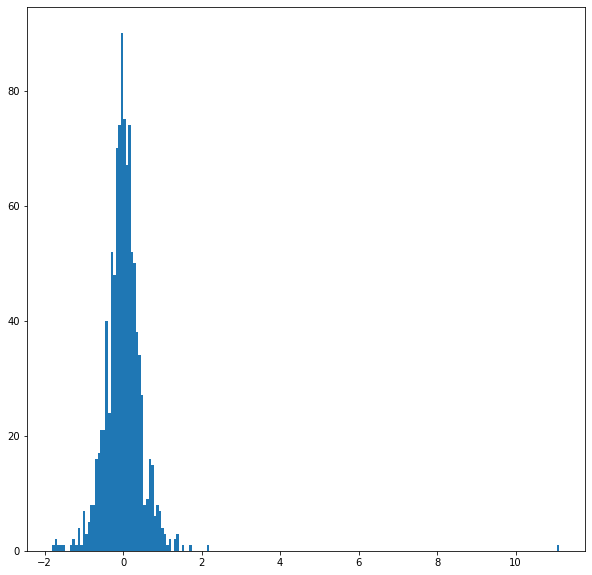

In [ ]:
# Import da biblioteca gráfica
import matplotlib.pyplot as plt
%matplotlib inline

# Para o oitavo token na sentença, seleciona os valores das características da camada 5.
layer_i = 5
batch_i = 0
token_i = 8
vec = hidden_states[layer_i][batch_i][token_i]

# Mostra as palavras com seu token_i
print((texto_tokenizado[token_i], tokens_indexado[token_i]))

# Desenha os valores como um histograma para mostrar sua distribuição
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Agrupar os valores por camada faz sentido para o modelo, mas para nossos propósitos, queremos que ele seja agrupado por token.

Dimensões atuais:

`[# camadas, # lotes, # tokens, # características]`

`[# layers, # batches, # tokens, # features]`

Dimensões desejadas:

`[# tokens, # camadas, # características]`

`[# tokens, # layers, # features]`

Felizmente, o PyTorch inclui a função `permute` para reorganizar facilmente as dimensões de um tensor.

No entanto, a primeira dimensão é atualmente uma lista Python!


In [ ]:
# `hidden_states` é uma lista  Python.
print('           Tipo de estados ocultos: ', type(hidden_states))

# Cada elemento na lista é um tensor torch.
print('Formato do Tensor para cada camada: ', hidden_states[0].size())

           Tipo de estados ocultos:  <class 'tuple'>
Formato do Tensor para cada camada:  torch.Size([1, 25, 1024])


Vamos combinar as 12 camadas para fazer todo esse grande tensor.

In [ ]:
# Concatena os tensores de todas as camadas. Usa o método `stack` para 
# criar uma nova dimensão no tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([25, 1, 25, 1024])

Vamos nos livrar da dimensão "batches", pois não precisamos dela.

In [ ]:
# Remove a dimensão 1, o lote "batches".
# Usa o método 'squeeze' para remover a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([25, 25, 1024])

Finalmente, podemos alternar as dimensões "layers" e "tokens" com `permute`.

In [ ]:
# Troca a dimensão 0 e 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([25, 25, 1024])

## 3.3. Criando vetores de palavras e sentenças a partir de estados ocultos

Agora, o que fazemos com esses estados ocultos? Gostaríamos de obter vetores individuais para cada um de nossos tokens, ou talvez uma única representação vetorial de toda a sentença, mas para cada token de nossa entrada, temos 12 vetores separados, cada um de comprimento 768.

Para obter os vetores individuais, precisamos combinar alguns dos vetores de camada ... mas qual camada ou combinação de camadas fornece a melhor representação? Os autores do BERT testaram isso alimentando diferentes combinações de vetores como recursos de entrada para um BiLSTM usado em uma tarefa de reconhecimento de entidade nomeada e observando as pontuações F1 resultantes.

(Imagem de [Jay Allamar](http://jalammar.github.io/illustrated-bert/)'s blog)


![alt text](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

Embora a concatenação das últimas quatro camadas tenha produzido os melhores resultados nessa tarefa específica, muitos dos outros métodos ocorrem em um segundo próximo e, em geral, é aconselhável testar versões diferentes para sua aplicação específica: os resultados podem variar.

Isso é parcialmente demonstrado ao observar que as diferentes camadas do BERT codificam tipos muito diferentes de informações, portanto, a estratégia de pool apropriada será alterada dependendo do aplicativo, porque diferentes camadas codificam diferentes tipos de informações. A discussão de Hanxiao sobre esse tópico é relevante, assim como seus experimentos analisando as visualizações de diferentes camadas do PCA treinadas em um conjunto de dados de notícias e observando as diferenças nas quatro separações de classe das diferentes estratégias de agrupamento:

(Imagens de [BERT-as-service](https://bert-as-service.readthedocs.io/en/latest/section/faq.html))

![alt text](https://bert-as-service.readthedocs.io/en/latest/_images/pool_mean.png)
![alt text](https://bert-as-service.readthedocs.io/en/latest/_images/pool_max.png)

O resultado é que, novamente **, a estratégia de pool correta (média, max, concatenação etc.) e as camadas usadas (quatro últimas, todas, última camada etc.) dependem do aplicativo**. Essa discussão sobre estratégias de agrupamento se aplica tanto a inserções inteiras de sentenças quanto a inserções individuais de tokens semelhantes a ELMO.







### Vetores de Palavras

Para dar alguns exemplos, vamos criar vetores de palavras de duas maneiras.

Primeiro, vamos **concatenar** as últimas quatro camadas, fornecendo um vetor de palavra única por token. Cada vetor terá o comprimento `4 x 768 = 3.072` ou `4 x 1024 = 4.096`.

#### Concatenando os vetores de palavras

In [ ]:
# Armazena um vetor de tokens, com o formato [25 x 4,096]
token_vecs_cat = []

# `token_embeddings` is a [25 x 13 x 768] ou [25 x 25 x 1024] tensor.

# Para cada token na sentença...
for token in token_embeddings:
    
    # `token` é um tensor[13 x 768]

    # Concatene os vetores (ou seja, juntando-os) a partir das quatro últimas    
    # Cada vetor da camada são 768 ou 1024 valores, então `cat_vec` é de tamanho 3,072 ou 4,096.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Usa `cat_vec` para representar `token`.
    token_vecs_cat.append(cat_vec)

print ('Formato é: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Formato é: 25 x 4096


#### Somando os vetores de palavras

Como método alternativo, vamos tentar criar os vetores de palavras **somando/summing** juntas as últimas quatro camadas.

In [ ]:
# Armazena o vetor de tokens, com o formato [25 x 768] ou [25 x 1024]
token_vecs_sum = []

# `token_embeddings` é um tensor [25 x 12 x 768] ou [25 x 24 x 1024].

# Para cada token na sentença...
for token in token_embeddings:

    # `token` é um tensor [12 x 768] ou [24 x 1024]

    # Soma o vetor das últimas quatro camadas.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Usa `sum_vec` para representar o `token`.
    token_vecs_sum.append(sum_vec)

print ('Formato é: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Formato é: 25 x 1024


### Gerando um vetores de embeddings para a sentenças(mean/média)

Para obter um único vetor para toda a sentença, temos várias estratégias dependentes de aplicativos, mas uma abordagem simples é calcular a penúltima camada hiden de cada token, produzindo um único vetor de 768 ou 1024 de comprimento.

In [ ]:
# `hidden_states` tem o formato [13 x 1 x 22 x 768] ou [25 x 1 x 22 x 1024]

# `token_vecs` é um tensor com o formato [22 x 768] ou [22 x 1024]
token_vecs = hidden_states[-2][0]

# Calcula a média de todos os 25 tokens do vetor.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [ ]:
print ("Vetor de embedding da sentença tem o formato:", sentence_embedding.size())

Vetor de embedding da sentença tem o formato: torch.Size([1024])


## 3.4. Confirmando vetores dependentes do contexto

Para confirmar que o valor desses vetores são de fato dependentes do contexto, vejamos as diferentes instâncias da palavra "banco" em nossa sentença de exemplo:

"Depois de roubar **dinheiro do banco**, o **ladrão de banco** foi visto sentado no **banco da praça** central."

Vamos encontrar o índice dessas três instâncias da palavra "banco" na sentença de exemplo.

In [ ]:
for i, token_str in enumerate(texto_tokenizado):
  print (i, token_str)

0 [CLS]
1 Depois
2 de
3 roubar
4 o
5 co
6 ##fre
7 do
8 banco
9 ,
10 o
11 lad
12 ##rão
13 de
14 banco
15 foi
16 visto
17 sentado
18 no
19 banco
20 da
21 praça
22 central
23 .
24 [SEP]


As palavras estão em 8, 14 e 19.

Para esta análise, usaremos os vetores de palavras da somados, concatenados e última camada.

Podemos tentar imprimir seus vetores para compará-los.

### Somando

#### Embeddings



base(arquivo/comunidade):
* - 

large(arquivo/comunidade):
* cofre do banco   tensor([ 0.1175,  0.2260, -1.7680, -1.4736, -4.0491])
* ladrão de banco  tensor([ 0.2538,  1.6631, -2.2089, -0.5098, -5.3738])
* banco da praça   tensor([ 0.3593,  4.1334, -0.1122, -1.5973, -3.6433])

In [ ]:
print('Os primeiro 5 valores do vetor para cada instância de "banco".')
print('')
print("cofre do banco  ", str(token_vecs_sum[8][:5]))
print("ladrão de banco ", str(token_vecs_sum[14][:5]))
print("banco da praça  ", str(token_vecs_sum[19][:5]))

Os primeiro 5 valores do vetor para cada instância de "banco".

cofre do banco   tensor([ 0.1175,  0.2260, -1.7680, -1.4736, -4.0491])
ladrão de banco  tensor([ 0.2538,  1.6631, -2.2089, -0.5098, -5.3738])
banco da praça   tensor([ 0.3593,  4.1334, -0.1122, -1.5973, -3.6433])


#### Comparando

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

base(arquivo/comunidade):
* -

large(arquivo/comunidade):
* Vetor de similaridade para significados *diferentes*:  0.78
* Vetor de similaridade para significados *similares*:  0.91
* Vetor de similaridade para significados *diferentes*:  0.79

In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "ladrão de banco" vs "banco da praça" (different meanings).
diferentes_bancos = 1 - cosine(token_vecs_sum[14], token_vecs_sum[19])

print('Vetor de similaridade para significados *diferentes*:  %.2f' % diferentes_bancos)

# Calculate the cosine similarity between the word bank
# in "ladrão de banco" vs "cofre do banco" (same meaning).
mesmo_banco = 1 - cosine(token_vecs_sum[14], token_vecs_sum[8])

print('Vetor de similaridade para significados *similares*:  %.2f' % mesmo_banco)

# Calculate the cosine similarity between the word bank
# in "cofre do banco" vs "banco da praça" (different meanings).
diferentes_bancos1 = 1 - cosine(token_vecs_sum[19], token_vecs_sum[8])

print('Vetor de similaridade para significados *diferentes*:  %.2f' % diferentes_bancos1)

Vetor de similaridade para significados *diferentes*:  0.78
Vetor de similaridade para significados *similares*:  0.91
Vetor de similaridade para significados *diferentes*:  0.79


### Concatenando

#### Embeddings



base(arquivo/comunidade):
* - 

large(arquivo/comunidade):
* cofre do banco   tensor([ 0.4261, -0.1251, -0.4406,  0.0736, -1.4059])
* ladrão de banco  tensor([ 0.4835,  0.1447, -0.4306,  0.3436, -1.4682])
* banco da praça   tensor([ 0.3631,  0.9212,  0.1919, -0.2493, -0.9418])

In [ ]:
print('Os primeiro 5 valores do vetor para cada instância de "banco".')
print('')
print("cofre do banco  ", str(token_vecs_cat[8][:5]))
print("ladrão de banco ", str(token_vecs_cat[14][:5]))
print("banco da praça  ", str(token_vecs_cat[19][:5]))

Os primeiro 5 valores do vetor para cada instância de "banco".

cofre do banco   tensor([ 0.4261, -0.1251, -0.4406,  0.0736, -1.4059])
ladrão de banco  tensor([ 0.4835,  0.1447, -0.4306,  0.3436, -1.4682])
banco da praça   tensor([ 0.3631,  0.9212,  0.1919, -0.2493, -0.9418])


#### Comparando

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

base(arquivo/comunidade):
* - 

large(arquivo/comunidade):
* Vetor de similaridade para significados *diferentes*:  0.77
* Vetor de similaridade para significados *similares*:  0.90
* Vetor de similaridade para significados *diferentes*:  0.77

In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "ladrão de banco" vs "banco da praça" (different meanings).
diferentes_bancos = 1 - cosine(token_vecs_cat[14], token_vecs_cat[19])

print('Vetor de similaridade para significados *diferentes*:  %.2f' % diferentes_bancos)

# Calculate the cosine similarity between the word bank
# in "ladrão de banco" vs "cofre do banco" (same meaning).
mesmo_banco = 1 - cosine(token_vecs_cat[14], token_vecs_cat[8])

print('Vetor de similaridade para significados *similares*:  %.2f' % mesmo_banco)

# Calculate the cosine similarity between the word bank
# in "cofre do banco" vs "banco da praça" (different meanings).
diferentes_bancos1 = 1 - cosine(token_vecs_cat[19], token_vecs_cat[8])

print('Vetor de similaridade para significados *diferentes*:  %.2f' % diferentes_bancos1)

Vetor de similaridade para significados *diferentes*:  0.77
Vetor de similaridade para significados *similares*:  0.90
Vetor de similaridade para significados *diferentes*:  0.77


### Última camada

#### Embeddings



base(arquivo/comunidade):
* - 

large(arquivo/comunidade):
* cofre do banco   tensor([ 0.4261, -0.1251, -0.4406,  0.0736, -1.4059])
* ladrão de banco  tensor([ 0.4835,  0.1447, -0.4306,  0.3436, -1.4682])
* banco da praça   tensor([ 0.3631,  0.9212,  0.1919, -0.2493, -0.9418])

In [ ]:
print(last_hidden_state.size())

#Remove a dimensão de tamanho 1
ultima_camada = last_hidden_state[0]

print(ultima_camada.size())

torch.Size([1, 25, 1024])
torch.Size([25, 1024])


In [ ]:
print('Os primeiro 5 valores do vetor para cada instância de "banco".')
print('')
print("cofre do banco  ", str(ultima_camada[8][:5]))
print("ladrão de banco ", str(ultima_camada[14][:5]))
print("banco da praça  ", str(ultima_camada[19][:5]))

Os primeiro 5 valores do vetor para cada instância de "banco".

cofre do banco   tensor([ 0.4261, -0.1251, -0.4406,  0.0736, -1.4059])
ladrão de banco  tensor([ 0.4835,  0.1447, -0.4306,  0.3436, -1.4682])
banco da praça   tensor([ 0.3631,  0.9212,  0.1919, -0.2493, -0.9418])


#### Comparando

Podemos ver que os valores diferem, mas vamos calcular a semelhança de cosseno entre os vetores para fazer uma comparação mais precisa.

base(arquivo/comunidade):
* -

large(arquivo/comunidade):
* Vetor de similaridade para significados *diferentes*:  0.78
* Vetor de similaridade para significados *similares*:  0.92
* Vetor de similaridade para significados *diferentes*:  0.77

In [ ]:
from scipy.spatial.distance import cosine

# Calcule a similaridade de cosseno entre as palavras banco
# Em "ladrão de banco" vs "banco da praça" (diferentes significados).
diferentes_bancos = 1 - cosine(ultima_camada[14], ultima_camada[19])

print('Vetor de similaridade para significados *diferentes*:  %.2f' % diferentes_bancos)

# Calcule a similaridade de cosseno entre as palavras banco
# Em "ladrão de banco" vs "cofre do banco" (mesmo significados).
mesmo_banco = 1 - cosine(ultima_camada[14], ultima_camada[8])

print('Vetor de similaridade para significados *similares*:  %.2f' % mesmo_banco)

# Calcule a similaridade de cosseno entre as palavras banco
# Em "cofre do banco" vs "banco da praça" (diferentes significados).
diferentes_bancos1 = 1 - cosine(ultima_camada[19], ultima_camada[8])

print('Vetor de similaridade para significados *diferentes*:  %.2f' % diferentes_bancos1)

Vetor de similaridade para significados *diferentes*:  0.78
Vetor de similaridade para significados *similares*:  0.92
Vetor de similaridade para significados *diferentes*:  0.77


## 3.5 Visualizando sentenças

Aqui, queremos mostrar a conexão entre os tokens de uma sentença usando a incorporação do BERT. Plotamos as inserções dos tokens em um subespaço, onde (0,1) e (1,0) são os marcadores de partida [CLS] e [SEP] e marcadores finais e finais da sentença.

Notebook original:
https://colab.research.google.com/drive/1TCgnpIwsr6uK4cP0Gk1RCCQrFy6s3Xc1

In [ ]:
# bibliotecas
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

Texto a ser plotado no gráfico.

In [ ]:
text = "O céu está azul hoje."

Adiciona os tokens especiais ao texto.

In [ ]:
# Adiciona o token especial.
texto_marcado = "[CLS] " + text + " [SEP]"

Depois de adicionar os tokens especais precisamos dividir o texto em tokens, precisamos converter o texto de uma lista de strings para uma lista de indeces de vocabulário.

In [ ]:
# Divide a sentença em tokens.
texto_tokenizado = tokenizer.tokenize(texto_marcado)

# Mapeia os tokens em seus índices do vocabuário    
tokens_indexado = tokenizer.convert_tokens_to_ids(texto_tokenizado)

# Mostra a sentença original.
print('Texto: ', text)

# Mostra as palavras com seus índices.
for tup in zip(texto_tokenizado, tokens_indexado):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

Texto:  O céu está azul hoje.
[CLS]           101
O               231
céu           8,242
está            698
azul          5,580
hoje          1,790
.               119
[SEP]           102


O BERT é treinado e espera pares de sentenças, usando 1s e 0s para distinguir entre as duas sentenças. Ou seja, para cada token em "texto_tokenizado", devemos especificar a qual sentença pertence: sentença 0 (uma série de 0s) ou sentença 1 (uma série de 1s). Para nossos propósitos, as entradas de sentença única requerem apenas uma série de 1s; portanto, criaremos um vetor de 1s para cada token em nossa sentença de entrada.

Se você deseja processar duas sentenças, atribua cada palavra na primeira sentença mais o token '[SEP]' a 0 e todos os tokens da segunda sentença a 1.

In [ ]:
# Marca cada um dos tokens como pertencentes à sentença "1".
segmento_ids = [1] * len(texto_tokenizado)

print(segmento_ids)
print(len(segmento_ids))

[1, 1, 1, 1, 1, 1, 1, 1]
8


Em seguida, precisamos converter nossos dados em tensores de tocha e chamar o modelo BERT. A interface BERT PyTorch exige que os dados estejam em tensores de tocha em vez de em listas Python; portanto, convertemos as listas aqui - isso não altera a forma ou os dados.


In [ ]:
# Converte a entrada em tensores PyTorch
tokens_tensor = torch.tensor([tokens_indexado])
segments_tensors = torch.tensor([segmento_ids])

A função `model()` executa o texto através do BERT. Os resultados do processamento serão retornados para `outputs[2]` ou `hidden_states`.

In [ ]:
# Roda o texto através do BERT, e coleta todos os estados ocultos produzidos
# das 12 camadas. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # A avaliação do modelo retorna um número de diferentes objetos com base em
    # como é configurado na chamada do método `from_pretrained` anterior. Nesse caso,
    # porque definimos `output_hidden_states = True`, o terceiro item será o
    # estados ocultos(hidden_states) de todas as camadas. Veja a documentação para mais detalhes:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel

    #Retorno de model quando ´last_hidden_state=True´ é setado:    
    #outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states

    hidden_states = outputs[0] 

O conjunto completo saída para este modelo, armazenados no objeto `outputs`, é um pouco grande. Este objeto tem três dimensões, na seguinte ordem: 

* O número do lote (1 sentença)
* O número de tokens (8 tokens)
* O número da unidade / recurso oculto (768 recursos)

A primeira dimensão, o tamanho do lote(batch size = 1), é usada ao enviar várias sentenças para o modelo de uma só vez; aqui, porém, temos apenas um exemplo de sentença.



In [ ]:
print ("Número de lotes(batches):", len(hidden_states))
batch_i = 0

print ("Número de tokens:", len(hidden_states[batch_i]))
token_i = 0

print ("Número de unidades ocultas:", len(hidden_states[batch_i][token_i]))

Número de lotes(batches): 1
Número de tokens: 8
Número de unidades ocultas: 1024


Vamos nos livrar da dimensão "batches", pois não precisamos dela.

In [ ]:
# Remove a dimensão 1, o lote "batches".
# O método squeeze remove a primeira dimensão(0) pois possui tamanho 1
token_embeddings = torch.squeeze(hidden_states, dim=0)

token_embeddings.size()

torch.Size([8, 1024])

Transforma  o vetor de embendings em um array.

In [ ]:
# Recupera o embeddings dos tokens como um vetor
embeddings = token_embeddings.numpy()

Base selecionada para que o [CLS] e o [SEP] passem para (0,1) e (1,0)

In [ ]:
# Converte para um array
W = np.array(embeddings)
# Transforma em um array
B = np.array([embeddings[0], embeddings[-1]])
# Invert B.T
Bi = np.linalg.pinv(B.T)

print(W.shape)
print(Bi.shape)

(8, 1024)
(2, 1024)


Projete os tokens da palavra no subespaço

In [ ]:
Wp = np.matmul(Bi,W.T)

print(Wp.shape)

(2, 8)


Plota o gráfico da sentença

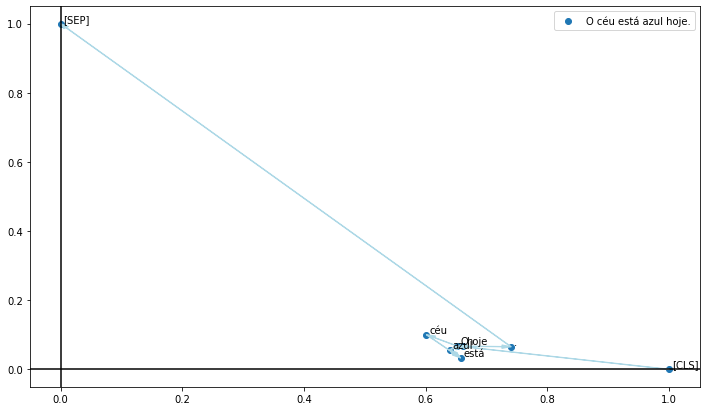

In [ ]:
plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
plt.scatter(Wp[0,:], Wp[1,:], label=text)
rX = max(Wp[0,:])-min(Wp[0,:])
rY = max(Wp[1,:])-min(Wp[1,:])
rM = max(rX, rY)
eps = 0.005
for i, txt in enumerate(texto_tokenizado):
    plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
    if i>0:
        plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color='lightblue', head_length=rM*eps*3, head_width=rM*eps*2, length_includes_head=True)

plt.legend()
plt.show()

Vamos criar uma função com as etapas anteriores para gerar as coordenadas de plotagem a partir das sentenças!

In [ ]:
def get_visual_embs(text, modelbert):
    
    # Adiciona os tokens especiais.
    texto_marcado = "[CLS] " + text + " [SEP]"

    # Divide a sentença em tokens.
    texto_tokenizado = tokenizer.tokenize(texto_marcado)

    # Mapeia cada string de token para seu índice no vocabulário.
    # Mesmo que mode.encode mas com parâmetros
    tokens_indexado = tokenizer.convert_tokens_to_ids(texto_tokenizado)
    
    # Marque cada um dos tokens como pertencentes à sentença "1".
    segmento_ids = [1] * len(texto_tokenizado)

    # Convertar as entradas em Tensores PyTorch
    tokens_tensor = torch.tensor([tokens_indexado])
    segments_tensors = torch.tensor([segmento_ids])

    # Prediz as características dos estados ocultos para cada camada
    with torch.no_grad():
      
        # A avaliação do modelo retorna um número de diferentes objetos com base em
        # como é configurado na chamada do método `from_pretrained` anterior. Nesse caso,
        # porque definimos `output_hidden_states = True`, o terceiro item será o
        # estados ocultos(hidden_states) de todas as camadas. Veja a documentação para mais detalhes:
        # https://huggingface.co/transformers/model_doc/bert.html#bertmodel

        # Retorno de model quando ´last_hidden_state=True´ é setado:    
        # outputs[0] = last_hidden_state, outputs[1] = pooler_output, outputs[2] = hidden_states

        outputs = modelbert(tokens_tensor, segments_tensors)

        # última camada embedding
        hidden_states = outputs[0]   

    # Remove a dimensão 1, os lotes("batches").
    token_embeddings = torch.squeeze(hidden_states, dim=0)

    # Recupera os embeddings dos tokens como um array
    embeddings = token_embeddings.numpy()

    # Converte para um array
    W = np.array(embeddings)
    # Transforma em um array
    B = np.array([embeddings[0], embeddings[-1]])
    # Inverte B.T
    Bi = np.linalg.pinv(B.T)

    # Projta o token da palavra no subespaço
    Wp = np.matmul(Bi,W.T)

    return Wp, texto_tokenizado

### Comparando sentenças

Ok, vamos investigar em sentenças diferentes!

Vamos mudar uma palavra na sentença!

['[CLS]', 'O', 'céu', 'está', 'azul', 'hoje', '.', '[SEP]']
['[CLS]', 'O', 'mar', 'está', 'azul', 'hoje', '.', '[SEP]']


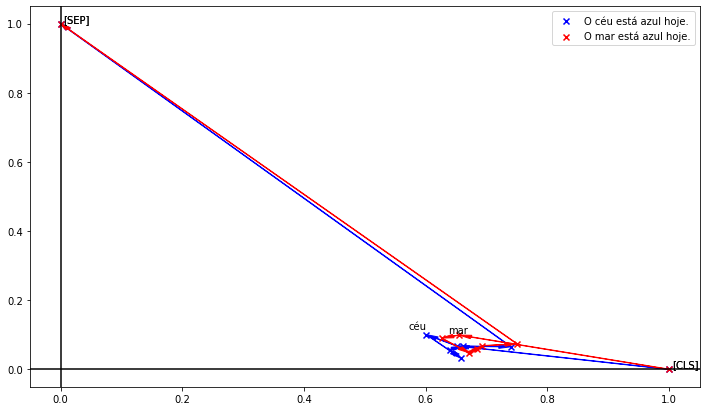

In [ ]:
sentences = ['O céu está azul hoje.', 'O mar está azul hoje.']
colors = ['blue', 'red']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s, model)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if txt == 'céu':
            plt.annotate(txt, (Wp[0,i]+rX*eps*-6, Wp[1,i]+rX*eps*3))
        if txt == 'mar':
            plt.annotate(txt, (Wp[0,i]+rX*eps*2, Wp[1,i]+rX*eps*3))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Agora, vamos mudar o tempo da sentença!

['[CLS]', 'Isto', 'é', 'uma', 'ideia', 'hor', '##rível', '!', '[SEP]']
['[CLS]', 'Isto', 'foi', 'uma', 'ideia', 'hor', '##rível', '!', '[SEP]']
['[CLS]', 'Isto', 'seria', 'uma', 'ideia', 'hor', '##rível', '!', '[SEP]']


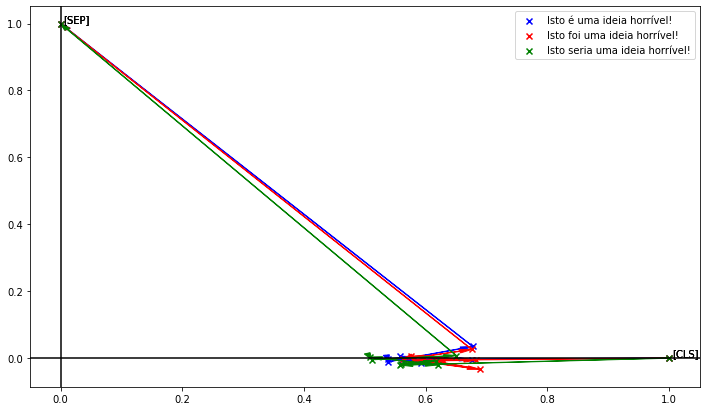

In [ ]:
sentences = ['Isto é uma ideia horrível!', 'Isto foi uma ideia horrível!', 'Isto seria uma ideia horrível!']
colors = ['blue', 'red', 'green']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s, model)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        #plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Caracteres de pontuação?

['[CLS]', 'Isto', 'é', 'uma', 'ideia', 'hor', '##rível', '.', '[SEP]']
['[CLS]', 'Isto', 'é', 'uma', 'ideia', 'hor', '##rível', '!', '[SEP]']
['[CLS]', 'Isto', 'é', 'uma', 'ideia', 'hor', '##rível', '?', '[SEP]']


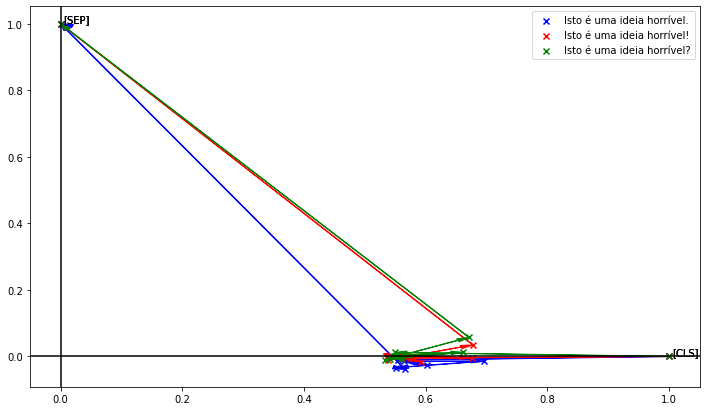

In [ ]:
sentences = ['Isto é uma ideia horrível.', 'Isto é uma ideia horrível!', 'Isto é uma ideia horrível?']
colors = ['blue', 'red', 'green', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s, model)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        #plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

sentenças complexas com Pilha no texto.

['[CLS]', 'A', 'pilha', 'é', 'uma', 'estrutura', 'de', 'dados', 'linear', '.', '[SEP]']
['[CLS]', 'Uma', 'pilha', 'permite', 'acesso', 'a', 'elementos', 'apenas', 'em', 'uma', 'extremidade', ',', 'o', 'topo', '.', '[SEP]']
['[CLS]', 'As', 'pilha', '##s', 'seguem', 'o', 'princípio', 'FI', '##F', '##O', '-', 'Fir', '##t', 'In', ',', 'Fir', '##st', 'Out', '.', '[SEP]']
['[CLS]', 'Em', 'uma', 'pilha', 'o', 'último', 'elemento', 'adicionado', 'é', 'o', 'primeiro', 'a', 'ser', 'removido', '.', '[SEP]']


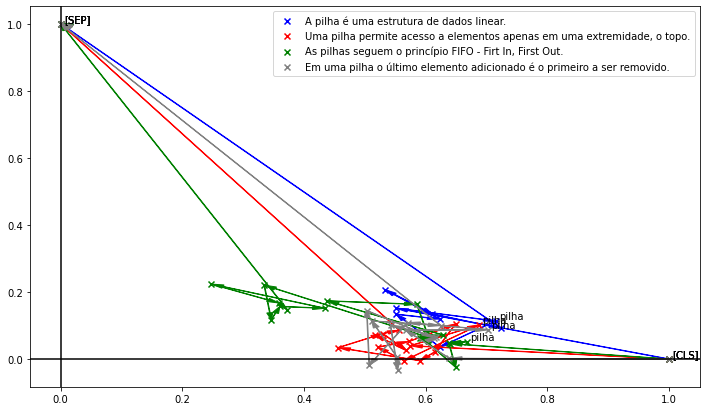

In [ ]:
sentences =["A pilha é uma estrutura de dados linear.",
            "Uma pilha permite acesso a elementos apenas em uma extremidade, o topo.",
            "As pilhas seguem o princípio FIFO - Firt In, First Out.",
            "Em uma pilha o último elemento adicionado é o primeiro a ser removido."]
            #"Os elementos em uma pilha são adicionados no topo e removidos dele também.",
            #"As pilhas podem ser implementadas usando um vetor ou lista ligada."]

colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s, model)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if txt in ['pilha','pilhas']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

Reações, diálogo

['[CLS]', 'Sim', ',', 'é', 'verdade', '!', '[SEP]']
['[CLS]', 'Claro', ',', 'ele', 'é', 'bem', 'sucedido', '.', '[SEP]']
['[CLS]', 'Não', 'foi', '?', '[SEP]']
['[CLS]', 'Eu', 'posso', 'concorda', '##r', 'totalmente', 'com', 'isso', '.', '[SEP]']
['[CLS]', 'No', 'entanto', ',', 'isso', 'não', 'pode', 'ser', 'visto', '.', '[SEP]']


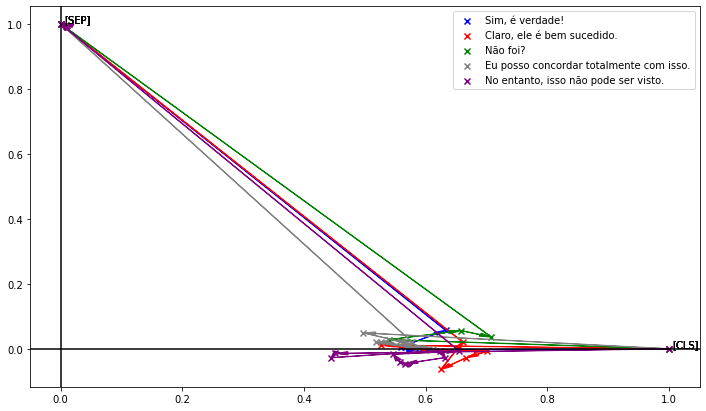

In [ ]:
sentences = ["Sim, é verdade!", 
             "Claro, ele é bem sucedido.",
             "Não foi?",
             "Eu posso concordar totalmente com isso.",
             "No entanto, isso não pode ser visto.",]

colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s, model)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()

sentenças não reais

['[CLS]', 'O', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', '[SEP]']
['[CLS]', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '[SEP]']
['[CLS]', 'gran', 'de', 'h', '##tha', '##te', '##h', 'he', '##ta', 'ger', 'er', '[SEP]']
['[CLS]', 'O', 'céu', 'está', 'azul', 'hoje', '.', '[SEP]']
['[CLS]', 'James', 'Cook', 'era', 'um', 'homem', 'muito', 'bom', 'e', 'um', 'marido', 'amoroso', '.', '[SEP]']


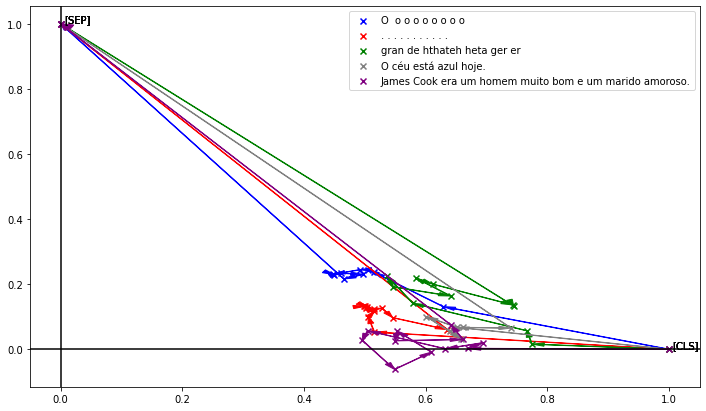

In [ ]:
sentences = ["O  o o o o o o o o", 
             ". . . . . . . . . . .",
             "gran de hthateh heta ger er",
             "O céu está laranja hoje.",
             "O carrocho está voando alto."]
colors = ['blue', 'red', 'green', 'grey', 'purple', 'orange', 'lightblue', 'yellow']

plt.figure(figsize=(12,7))
plt.axhline(color='black')
plt.axvline(color='black')
for n,s in enumerate(sentences):
    Wp, tokens = get_visual_embs(s, model)
    print(tokens)
    plt.scatter(Wp[0,:], Wp[1,:], color=colors[n], marker='x', label=s)
    rX = max(Wp[0,:])-min(Wp[0,:])
    rY = max(Wp[1,:])-min(Wp[1,:])
    rM = max(rX, rY)
    eps = 0.005
    eps2 = 0.005
    for i, txt in enumerate(tokens):
        if txt in ['[CLS]', '[SEP]']:
            plt.annotate(txt, (Wp[0,i]+rX*eps, Wp[1,i]+rX*eps))
        if i>0:
            plt.arrow(Wp[0,i-1],Wp[1,i-1], Wp[0,i]-Wp[0,i-1], Wp[1,i]-Wp[1,i-1], color=colors[n], head_length=rM*eps2*4, head_width=rM*eps2*2, length_includes_head=True)
plt.legend()
plt.show()